In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
from math import cos,sin,pi
import random
import rpy2
import scipy

import seaborn as sns

folder_path = './datas/flip/'
pcanum = 20
o=pi/6
rand = 0.05
rand_max = 5;

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [4]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 800
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

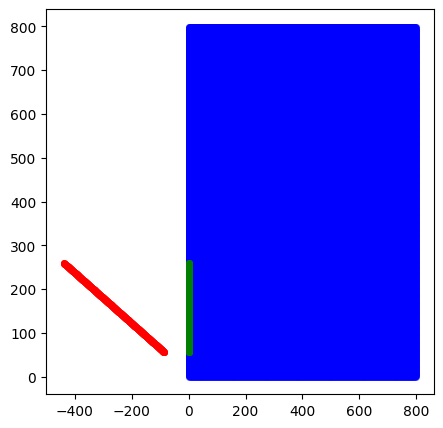

View of AnnData object with n_obs × n_vars = 205 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'

In [123]:
a,b  =simulate_spatial(datas,pi/3)
a

In [114]:
a.obsm['spatial']

ArrayView([[147, 113],
           [399, 383],
           [231, 130],
           ...,
           [336, 281],
           [181, 356],
           [256, 151]])

In [18]:
def rotate(x,y,o):
    x = x*cos(o) - y *sin(o)
    y = x*sin(o) + y *cos(o)
    return x,y

In [56]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
count_sub = datas.to_df()
xy_coords = datas.obs[['imagerow',"imagecol"]]
for i in range(len(xy_coords)):
    x = xy_coords.iloc[i][0]
    y = xy_coords.iloc[i][1];

    x,y =rotate(x,y,o)
    xy_coords.iloc[i][0] = x;
    xy_coords.iloc[i][1] = y;
    
for i in range(len(count_sub)):
    for j in range(len(count_sub.iloc[0])):
        if(random.random() < rand):
            rand_gene = random.randint(1,rand_max);
        count_sub.iloc[i][j] += rand_gene

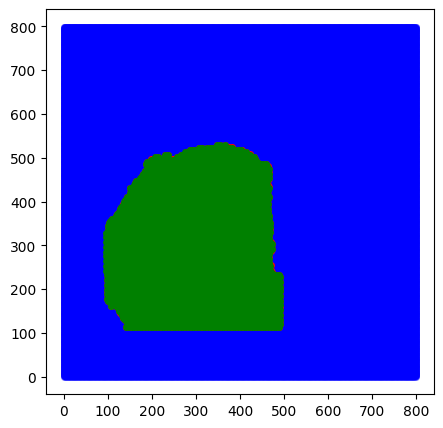

View of AnnData object with n_obs × n_vars = 4220 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'

In [5]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,0);
datas
# count_sub = datas.to_df()
# xy_coords = datas.obs[['imagerow',"imagecol"]]

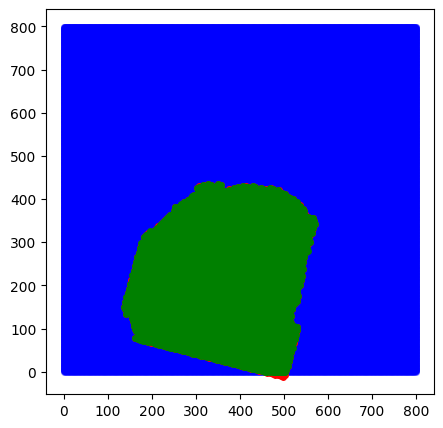

In [16]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,-pi/12);

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)


In [ ]:
# count_sub = datas.to_df()
# xy_coords = datas.obs[['imagerow',"imagecol"]]

In [1]:

xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

NameError: name 'xy_coords' is not defined

In [18]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9948 by 4220

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 4220 cells



  |======================================================================| 100%


R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 9948 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9948 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 42.50319 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  4220 
## number of total features:  9948 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  722  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  722  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0305207450677827  
## Calculating kernel matrix
## Finished calculating kernel matrix.


In [19]:
folder_path

'./datas/flip/'

In [7]:
adata1 = pd.read_csv(folder_path+"pca.csv")
adata1 = adata1.set_index(adata1.columns[0]).T
adata1.index = adata1.index.str.replace('.', '-')
adata1 = anndata.AnnData(adata1)

cell_meta = pd.read_csv(folder_path+"meta_data.csv")
cell_meta = cell_meta.set_index(cell_meta.columns[0])
adata1.obs = cell_meta
adata1.obsm['X_pca'] = adata1.to_df()
# # adata1.obs['celltype'] = cell_meta.values




/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_3501/953224956.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata1.index = adata1.index.str.replace('.', '-')
/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_3501/953224956.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1 = anndata.AnnData(adata1)
/Users/dongjiajie/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
adata1.to_df()

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,-4.167609,-0.222282,2.499456,-0.079415,-0.754790,0.011324,-0.723582,0.542454,0.214794,-0.419974,0.295130,0.340520,-0.783750,-0.748803,-1.071784,-0.937515,-0.354972,0.686161,-0.203911,-0.114342
AAACAAGTATCTCCCA-1,2.577250,-0.188854,0.727778,-0.040442,0.379885,0.503064,-0.149041,-1.214029,0.595438,-0.642548,-0.366804,0.095848,0.011809,0.060024,0.648140,0.512396,-0.093132,0.106520,-0.539648,-0.078734
AAACAATCTACTAGCA-1,-4.577958,-4.033122,-2.314545,-0.180609,2.407337,-1.438138,0.630240,0.758675,-0.901130,-0.619935,-1.528688,-0.379222,0.319920,0.683396,-0.371077,-0.061150,-0.545392,0.493990,-0.047754,1.270696
AAACACCAATAACTGC-1,-6.395294,6.286880,-3.865755,-2.135113,0.136510,0.536887,-0.104846,-0.388041,-0.755875,0.486827,-0.144664,-1.412633,0.051442,0.126907,-0.720560,-1.160350,-0.870530,0.316672,0.370826,-0.156495
AAACAGCTTTCAGAAG-1,1.498800,0.846281,1.204402,1.127950,-0.187625,1.445982,4.731232,-1.123366,0.005325,-1.710737,-1.407492,1.614022,-0.700926,0.154335,-0.459761,1.452870,0.281153,-1.810453,-0.229577,-1.396537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1.677025,-1.690353,0.306345,-1.445187,0.513261,0.355382,-0.046588,-0.086755,0.446190,0.500392,0.240689,-0.795115,0.256409,-0.317069,-0.446138,0.242551,-0.318610,-0.630809,-0.549218,0.153888
TTGTTTCACATCCAGG-1,0.496095,2.213734,0.348133,-0.765845,-0.581962,-1.037302,0.551710,0.373199,0.589580,0.330093,-0.288059,-0.082863,0.090676,-0.119646,-0.749088,1.065174,0.823410,-0.494540,-0.038673,-0.039758
TTGTTTCATTAGTCTA-1,-6.705557,4.984181,0.245194,0.570425,-0.768743,2.482265,-0.114982,0.611494,2.023068,0.798139,-0.167188,1.276093,0.509759,3.181810,1.349113,0.367461,0.057369,0.615497,-1.235171,0.117873


In [9]:
adata1.raw = adata1

sc.pp.neighbors(adata1,
                n_neighbors=10,
                use_rep='X_pca',
                random_state=1234
                )
sc.tl.diffmap(adata1,random_state=1234)
sc.tl.umap(adata1,random_state=1234)
sc.tl.leiden(adata1,random_state=1234,resolution = 0.5)
sc.tl.paga(adata1, groups='leiden')


In [10]:
set_initial_condition(adata1);


In [11]:
inter_gene = sort_data(adata1,adata1,N_1=None,N_2=None)

20 genes are used to calculate cost of tree alignment.



./datas/flip/datas.data length:4220
Generating all pairs subset


100%|██████████| 1563/1563 [01:11<00:00, 21.82ex/s, loss=0.998737] 


	 Epoch 9 | average train loss: 1.025699
Optimization finished.


/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/stst/utils/visualization.py:23: RuntimeWarning: invalid value encountered in divide
  return np.tanh(t * np.arctanh(normx)) * x / normx


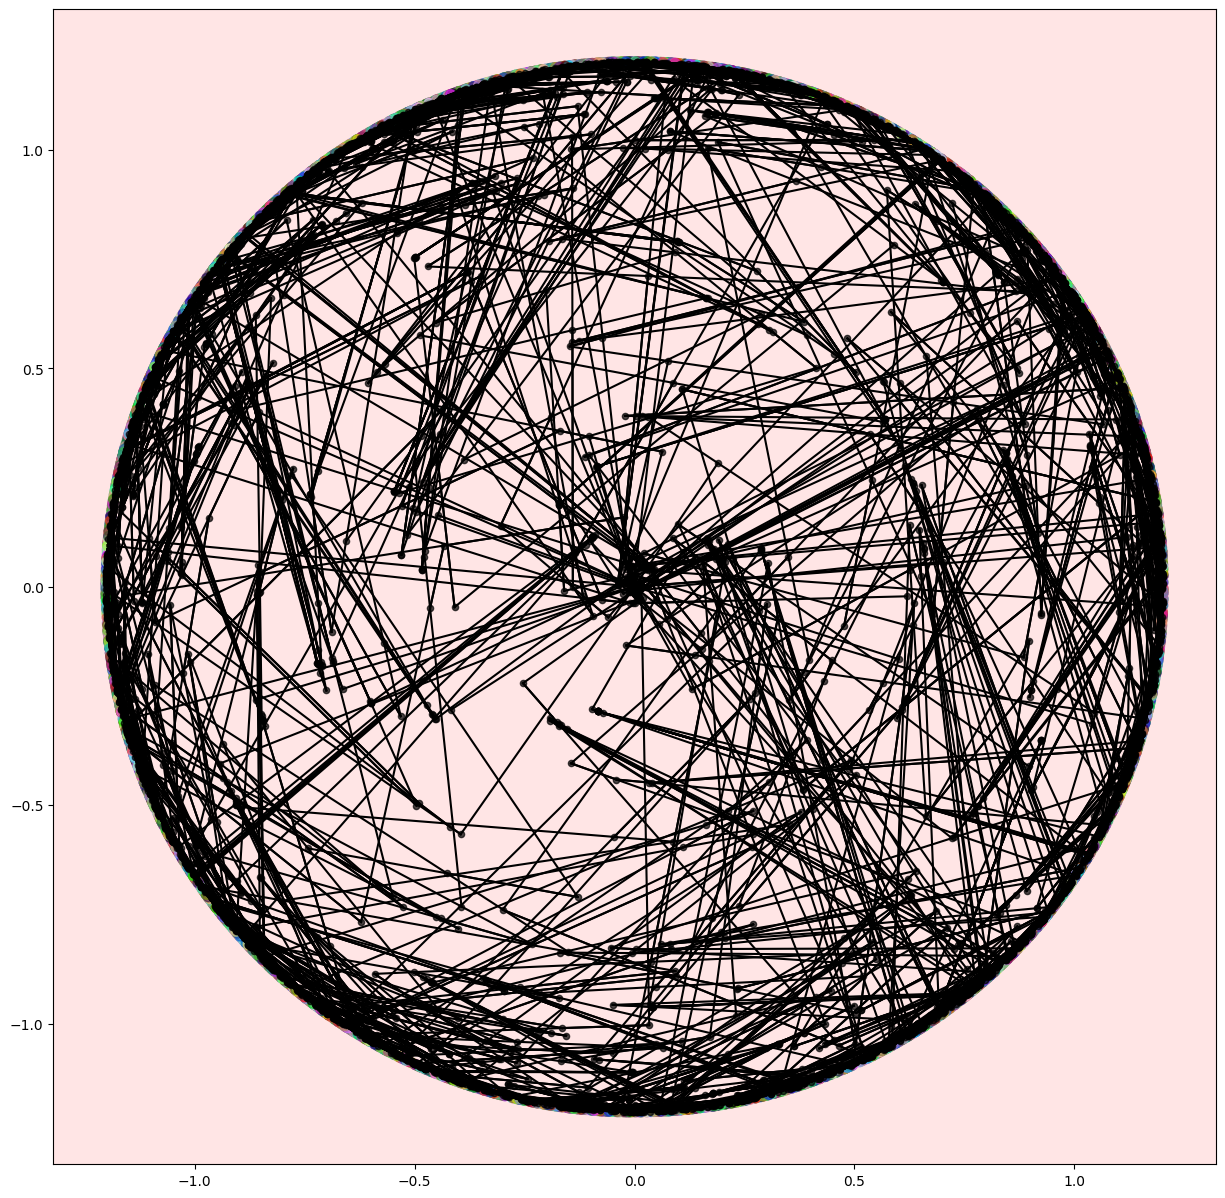

In [12]:
pd.DataFrame(adata1.X).to_csv(folder_path+"datas.data",header=None)
pd.DataFrame(adata1.X).to_csv(folder_path+"datas.csv")

get_Hyper_tree(folder_path+'datas.data',1,20+1,0,10,model_path=None,save_path=folder_path,c=0)


In [11]:
calculate_cluster_centroid_for_genes

<function datasets.preprecossing.calculate_cluster_centroid_for_genes(adata, gene_list, save_path='./')>

In [12]:
tmp1 = calculate_cluster_centroid_for_genes(adata1,inter_gene,folder_path)
tmp1

Unnamed: 0,20,10,15,8,19,1,16,17,4,2,5,7,14,13,9,11,3,12,18,6
0,0.196886,0.211345,-0.022468,0.561866,-0.059321,-4.520456,-0.011834,0.074445,-0.124779,-2.213684,0.206805,0.147810,-0.051927,0.131771,0.102731,-0.425186,0.258949,-0.099777,-0.125524,-0.506390
1,-0.050896,-0.063176,-0.238843,-0.091663,0.044198,2.598221,0.097852,0.095535,-1.202380,-1.452555,-0.157287,-0.155307,0.193625,0.120059,0.054634,-0.170846,0.013259,-0.192677,0.019624,0.503642
2,-0.136574,-0.406652,0.281442,-0.256270,0.138925,-3.920883,-0.050128,-0.066513,0.693264,-2.307537,0.084299,-0.045436,-0.073580,0.060336,0.511299,0.305164,-0.478705,0.138804,0.029563,-0.388934
3,0.027051,-0.098618,0.038182,-0.268312,-0.218902,0.080376,-0.440480,0.182071,-0.808251,-0.873180,-0.114618,-0.320820,0.011278,-0.074205,-0.955099,0.107097,1.393379,0.135423,-0.324824,0.188698
4,-0.155264,0.181426,-0.096171,-0.011208,-0.049471,-6.155461,0.132389,0.033503,-1.044841,4.014405,-0.400909,-0.018854,0.299685,0.070569,0.176392,0.076867,-1.085564,0.007037,0.032579,0.880562
5,-0.169905,0.687930,-0.106354,-0.039781,0.015606,0.545755,0.265986,0.041208,0.700059,-2.259269,-0.599507,0.404249,-0.108543,-0.340337,-0.206115,0.089228,-1.914517,-0.183410,-0.148217,0.155235
6,0.155384,-0.193653,0.087361,0.323191,0.075259,2.928479,0.244612,-0.202799,-0.788710,0.323078,1.487711,-0.258076,-0.208024,-0.265103,0.434666,-0.116826,0.467047,-0.060684,0.139997,0.272326
7,0.127359,0.139800,0.490225,-0.372213,-0.129276,2.894293,-0.214831,0.086838,1.374215,1.294466,0.333113,-0.579613,0.127568,0.265508,0.002597,0.263380,-0.079656,-0.140090,-0.128949,-0.050780
8,-0.144078,-0.444045,-0.331353,-0.317993,0.114159,2.763957,-0.195143,-0.020446,0.789495,-0.651808,-0.878677,-0.599518,-0.072404,0.262204,0.479316,-0.141205,-0.586979,0.489599,-0.142154,0.763758
9,-0.201513,-0.132803,-0.066494,0.682482,0.108451,1.563471,-0.146724,-0.258633,-0.094827,0.631714,1.206854,0.215022,0.154909,-0.410360,-0.470829,0.296520,0.696390,0.263237,0.022823,-0.070282


./datas/flip/datas.data length:16
Generating all pairs superset


100%|██████████| 1563/1563 [01:08<00:00, 22.74ex/s, loss=0.787558] 


	 Epoch 9 | average train loss: 0.915040
Optimization finished.


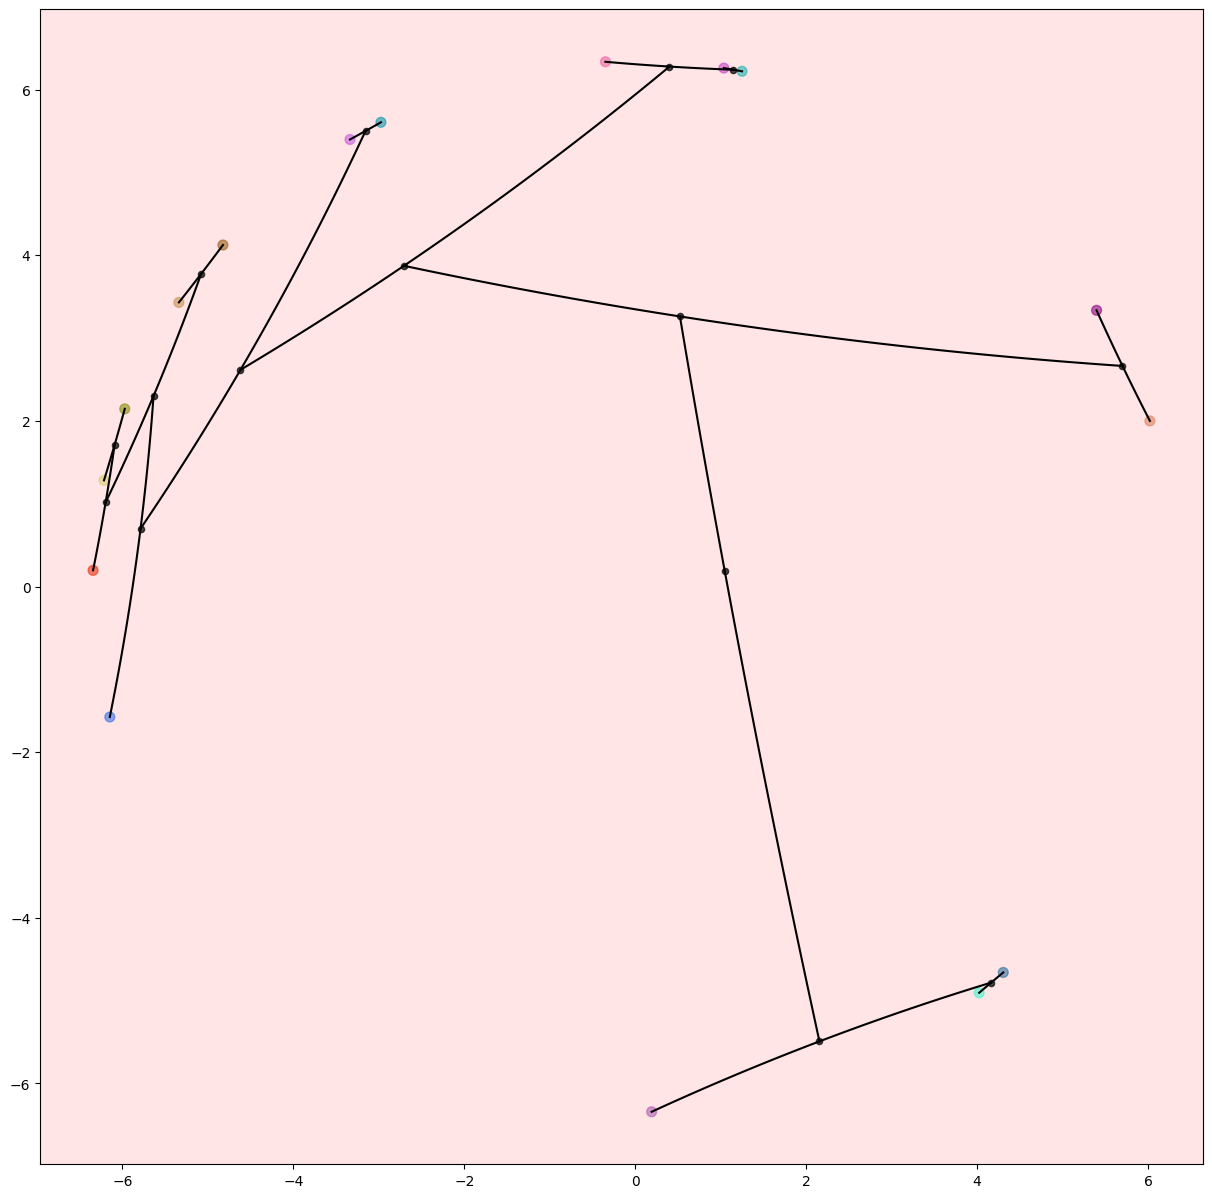

In [13]:
get_Hyper_tree(folder_path+'datas.data',1,tmp1.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=0)


In [21]:
adata1.obs['leiden'].to_csv(folder_path+'leiden.csv')

[]

In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
from math import cos,sin,pi
import random
import rpy2
import scipy

import seaborn as sns

folder_path = './datas/flip/'
pcanum = 20
o=pi/6
rand = 0.05
rand_max = 5;

In [5]:
df = pd.DataFrame(
                {"A": [0], "B":[0]})

In [2]:
nodes1,n1 = build_hyper_tree('./datas/719/')
# show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree('./datas/flip/')
# show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
# G.show_fig()
print("average cost for one node:{}".format(minn/(n1+n2)))

In [42]:
label1 = pd.read_csv("./datas/719/leiden.csv")
label1 = label1.set_index(label1.columns[0])
label1
label2 = pd.read_csv("./datas/flip/leiden.csv")
label2 = label2.set_index(label2.columns[0])
label2

,leiden
Unnamed: 0,
AAACAACGAATAGTTC-1,3
AAACAAGTATCTCCCA-1,7
AAACAATCTACTAGCA-1,0
AAACACCAATAACTGC-1,4
AAACAGCTTTCAGAAG-1,13
...,...
TTGTTGTGTGTCAAGA-1,11
TTGTTTCACATCCAGG-1,10
TTGTTTCATTAGTCTA-1,4


In [54]:
all = len(label1);
count =0;
for i in range(len(label1)):
    l1 = label1.iloc[i][0];
    l2 = label2.iloc[i][0];
    if(ans.__contains__( (str(l1),str(l2)) ) ):
        count +=1
print(count/all);

0.00971563981042654


In [49]:
ans.__contains__(('1','2'))

False

In [47]:
(label1.index == label2.index).all()

True

In [45]:
label2

,leiden
Unnamed: 0,
AAACAACGAATAGTTC-1,3
AAACAAGTATCTCCCA-1,7
AAACAATCTACTAGCA-1,0
AAACACCAATAACTGC-1,4
AAACAGCTTTCAGAAG-1,13
...,...
TTGTTGTGTGTCAAGA-1,11
TTGTTTCACATCCAGG-1,10
TTGTTTCATTAGTCTA-1,4
